In [28]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import * 

%load_ext autoreload
%autoreload 2


niks_domain = 'NIKS'
ycf_domain = 'Y.C'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

def load_msa(path:str='../data/arf1_cleaned.afa', ids:list=arf1_df.index):
    msa_df = FASTAFile().from_fasta(path).to_df()
    msa_df = msa_df.loc[ids].copy()
    msa_arr = [list(seq) for seq in msa_df.seq]
    return msa_df.index.values, np.array(msa_arr)

index, alignment = load_msa()

In [3]:
conservation_threshold = 0.8
# Flag conserved positions as those where at least 80 percent of the sequences do not have a gap. 
is_conserved = lambda col : (col != '-').astype(int).mean() > conservation_threshold

conserved_positions = np.where([is_conserved(col) for col in alignment.T])[0]
print('Num. conserved positions:', len(conserved_positions))

alignment = alignment[:, conserved_positions]

seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical NIKS domain and YXCXXXF.

niks_match = re.search(niks_domain, seq)
ycf_match = re.search(ycf_domain, seq, flags=re.DOTALL)

niks_start, niks_stop = niks_match.start(), niks_match.end()
ycf_start, ycf_stop = ycf_match.start(), ycf_match.end()

# There are some clear outliers, potentially worth discarding for a better alignment. 

Num. conserved positions: 408


In [29]:
h = mutual_information(alignment)

/home/prichter/Documents/pyrrolysine/notebooks/utils.py:59: RuntimeWarning: invalid value encountered in scalar divide
  h[i, j] = (h_i(i, f) + h_i(j, f) - h_ij(i, j)) / h_ij(i, j)


In [34]:
h[h == 1] = np.nan

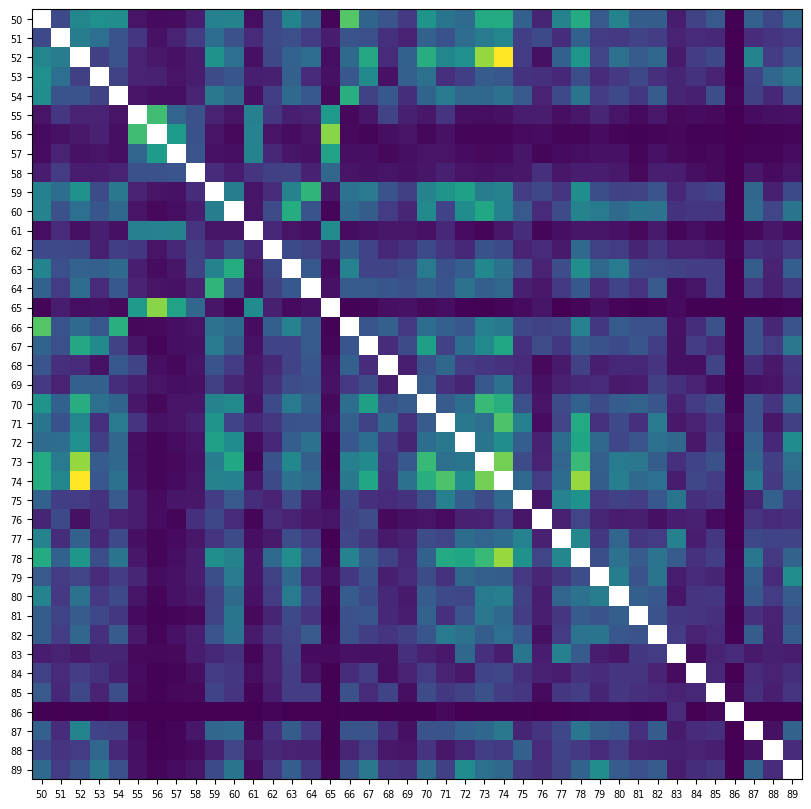

In [42]:
start, stop = 50, 90
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(h[start:stop, start:stop])
ax.set_xticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
plt.show()

In [4]:
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['group'] = np.where(arf1_df.has_pyl, 'pyl', 'no_pyl')

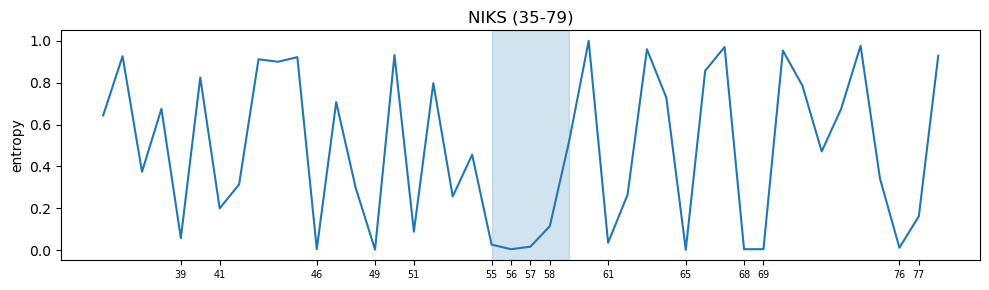

In [5]:
def figure(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, highlight:tuple=None, title:str=None, max_entropy:float=0.2):
    fig, ax = plt.subplots(figsize=(10, 3))

    alignment = alignment[:, start - delta:stop + delta].copy() # start - delta is the new zero. 
    offset = (start - delta)

    for aa, symbol in dayhoff.items():
        alignment[alignment == aa] = symbol

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    entropies = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])
    entropies = entropies / entropies.max()

    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax)

    x_ticks = np.where(entropies < max_entropy)[0]
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_title(f'{title} ({start - delta}-{stop + delta})')
    ax.set_ylabel('entropy')

    if highlight is not None:
        x_min, x_max = highlight
        ax.axvspan(x_min - offset, x_max - offset, alpha=0.2, color='tab:blue')

    fig.tight_layout()
    plt.show()

    return np.where(entropies < max_entropy)[0] + offset, entropies

positions, entropies = figure(alignment, start=niks_start, stop=niks_stop, highlight=(niks_start, niks_stop), title='NIKS', max_entropy=0.2)
# positions = figure(alignment, start=ycf_start, stop=ycf_stop, highlight=(ycf_start, ycf_stop), title='YxCxxxF', max_entropy=20)

In [6]:
def figure_2(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, color:str=None, ax=None, label=None, scale:np.ndarray=None):

    alignment = alignment[:, start - delta:stop + delta] # start - delta is the new zero. 
    offset = (start - delta)

    for aa, symbol in dayhoff.items():
        alignment[alignment == aa] = symbol
    # conserved = [np.all(column == column[0]) for column in alignment.T]
    # print('Num. completely conserved residues:', sum(conserved))

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    entropies = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])
    entropies = entropies / entropies.max() # Normalize the entropies to 1. 
    x_ticks = np.where(entropies < 0.25)[0]
    
    if scale is not None:
        entropies = entropies - scale

    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax, color=color, label=label)
    
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_ylabel('entropy')

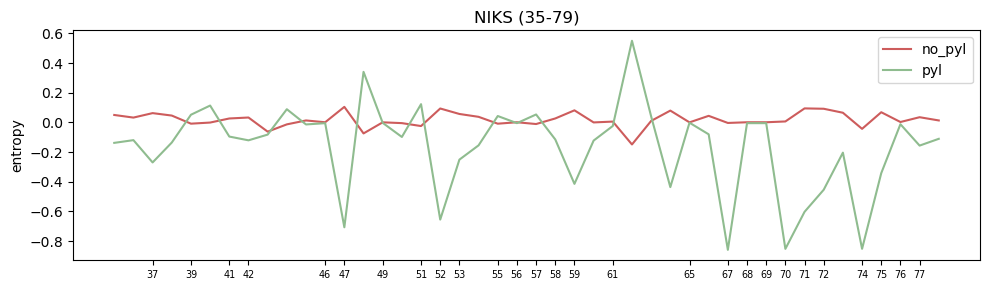

In [7]:
palette = {'pyl':'darkseagreen', 'no_pyl':'indianred'}

delta = 20
fig, ax = plt.subplots(figsize=(10, 3))
for group, df in alignment_df.groupby('group'):
    figure_2(df.values, start=niks_start, stop=niks_stop, color=palette[group], ax=ax, label=group, scale=entropies)
ax.set_title(f'NIKS ({niks_start - delta}-{niks_stop + delta})')
ax.legend()

fig.tight_layout()
plt.show()

In [8]:
def figure_3(alignment_df:pd.DataFrame, position:int=None, palette={'pyl':'darkseagreen', 'no_pyl':'indianred'}, ax=None):
    # fig, (ax_top, ax_bottom) = get_split_figure((0, 0.0025), (0.97, 0.98))

    figure_df = alignment_df[['group', position]].copy()
    sns.histplot(figure_df, x=position, hue='group', multiple='dodge', ax=ax, palette=palette)
    ax.set_ylabel('count')
    # ax.set_yscale('log')
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')

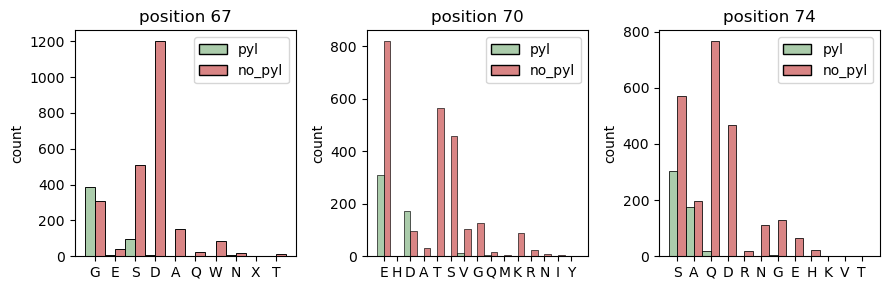

In [9]:
positions = [67, 70, 74]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure_3(alignment_df, position=position, ax=ax)
fig.tight_layout()
plt.show()

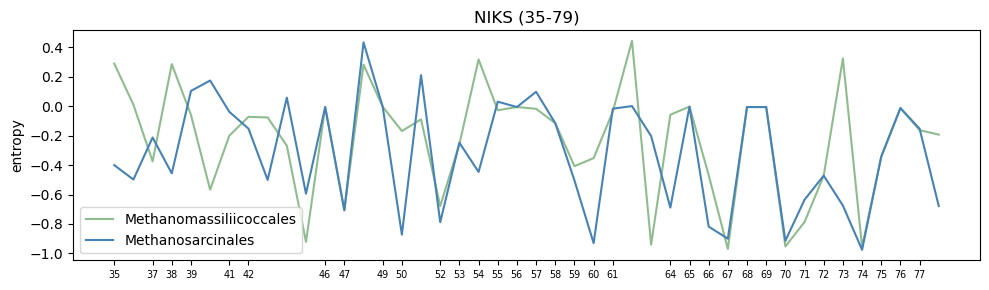

In [10]:
palette = {'Methanosarcinales':'steelblue', 'Methanomassiliicoccales':'darkseagreen'}

figure_df = alignment_df.copy()
figure_df['group'] = arf1_df['order'].values
figure_df = figure_df[arf1_df.has_pyl].copy()
figure_df['group'] = np.where(~figure_df['group'].isin(palette.keys()), 'other', figure_df['group'])
figure_df = figure_df[figure_df.group != 'other'].copy()

delta = 20
fig, ax = plt.subplots(figsize=(10, 3))
for group, df in figure_df.groupby('group'):
    figure_2(df.values, start=niks_start, stop=niks_stop, color=palette.get(group, 'gray'), ax=ax, label=group, scale=entropies)
ax.set_title(f'NIKS ({niks_start - delta}-{niks_stop + delta})')
# ax.axhline(1, color='gray', ls='--', lw=0.7)
# ax.set_ylim(ymax=1, ymin=0)
fig.tight_layout()
plt.show()

In [22]:
pyl_idxs = np.where(arf1_df.has_pyl)[0]
no_pyl_idxs = np.where(~arf1_df.has_pyl)[0]

pyl_alignment = alignment[pyl_idxs].copy()
no_pyl_alignment = alignment[no_pyl_idxs].copy()

pyl_alignment = [''.join(residues) for residues in pyl_alignment[:, [67, 70, 74]]]
no_pyl_alignment = [''.join(residues) for residues in no_pyl_alignment[:, [67, 70, 74]]]

In [23]:
np.unique(pyl_alignment)

array(['AEQ', 'DEQ', 'DVQ', 'EDA', 'EHA', 'GDA', 'GDS', 'GEA', 'GES',
       'GGA', 'GQA', 'GSS', 'NEA', 'NEN', 'NVQ', 'SDA', 'SDG', 'SDQ',
       'SDS', 'SEA', 'SEQ', 'SES', 'STQ', 'SVQ'], dtype='<U3')

In [26]:
np.isin(no_pyl_alignment, pyl_alignment).sum()

np.int64(572)